Import all dependancies

In [26]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
import copy as copy
import random as random
import json
# from transforms import get_transforms

# TODO: Handle relative paths correctly so we can all run it independantly and add to the readme where the dataset needs to be stored
# dataset_path = r"C:\Users\chris\Desktop\University\Code\ComputerVision\ForestNetDataset"
dataset_path = r"C:\Users\yaren\OneDrive\Desktop\TU Delft CSE\Masters\CV\deep\downloads\ForestNetDataset"

Initialise Random Seed

In [27]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Load the dataset into memory

In [28]:
# Join the directory with each CSV filename.
test_path = os.path.join(dataset_path, "test.csv")
train_path = os.path.join(dataset_path, "train.csv")
validation_path = os.path.join(dataset_path, "val.csv")

# Read the CSV files into pandas DataFrames.
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(validation_path)

# Create a mapping from the string labels to integers based on the training data.
labels = sorted(train_df["merged_label"].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
print("Label mapping:", label_to_index)


# FOR MODEL DEVELOPMENT JUST USE THE FIRST 128 SAMPLES FROM THE TRAINING SET
# train_df = train_df.head(128)

Label mapping: {'Grassland shrubland': 0, 'Other': 1, 'Plantation': 2, 'Smallholder agriculture': 3}


Balance the training set

In [29]:
# Print counts per class before oversampling
print("Counts per class before oversampling:")
print(train_df["merged_label"].value_counts())

# Get the maximum count among classes
max_count = train_df["merged_label"].value_counts().max()

# For each class, sample max_count examples with replacement.
balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("After oversampling, counts per class:")
print(balanced_train_df["merged_label"].value_counts())
train_df = balanced_train_df

Counts per class before oversampling:
merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64
After oversampling, counts per class:
merged_label
Grassland shrubland        686
Other                      686
Plantation                 686
Smallholder agriculture    686
Name: count, dtype: int64


C:\Users\yaren\AppData\Local\Temp\ipykernel_6112\2026690318.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(


Define DataLoaders for the training and test set

In [30]:
import imgaug.augmenters as iaa
import torchvision.transforms as T
import albumentations as A


# Dataset constants
# Hao: input size should be divisible by 32 and more than 64 pixels.
# https://github.com/qubvel/segmentation_models.pytorch/issues/18
RESIZE_SIZE = 300  # TODO: These dims should be cross-validated
RESIZE_SIZE_SENT2 = 450
INPUT_SIZE = 224
INPUT_SIZE_SENT2 = 320
AGGRESSIVE_INPUT_SIZE = 160
AGGRESSIVE_INPUT_SIZE_SENT2 = 256
SMALL_RESIZE_SIZE = 150
SMALL_RESIZE_SIZE_SENT2 = 240
LABEL_IGNORE_VALUE=255

SPATIAL_AUGMENTATIONS = {
    "none": [iaa.Identity()],
    "flip": [iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5)])],
    "affine":
    [iaa.SomeOf(2, [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            translate_percent={"x": (-0.03, 0.03), "y": (-0.03, 0.03)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Rot90(1, 3)
    ])],
    "cloud":
    [iaa.Sequential([
        iaa.SomeOf(2, [
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Rot90(1, 3)]),
        iaa.Sometimes(0.5,
                      iaa.OneOf([
                          iaa.Clouds(),
                          iaa.Fog(),
                          iaa.Snowflakes()]))])],
    "affine_cloud":
    [iaa.Sequential([
        iaa.SomeOf(2, [
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                cval=LABEL_IGNORE_VALUE,
                mode='constant'),
            iaa.Affine(
                translate_percent={"x": (-0.03, 0.03), "y": (-0.03, 0.03)},
                cval=LABEL_IGNORE_VALUE,
                mode='constant'),
            iaa.Rot90(1, 3)]),
        iaa.Sometimes(0.5,
                      iaa.OneOf([
                          iaa.Clouds(),
                          iaa.Fog(),
                          iaa.Snowflakes()]))])],
    "sap":
    [iaa.SomeOf(2, [
        iaa.SaltAndPepper([0.0, 0.01]),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            translate_percent={"x": (-0.03, 0.03), "y": (-0.03, 0.03)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            rotate=(-5, 5),
            cval=LABEL_IGNORE_VALUE,
            mode='constant')
    ])],
    "aggressive":
    [iaa.SomeOf(2, [
        iaa.SaltAndPepper([0.0, 0.1]),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            rotate=(-5, 5),
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.Affine(
            shear=(-5, 5),
            cval=LABEL_IGNORE_VALUE,
            mode='constant'),
        iaa.ElasticTransformation(alpha=(0.0, 40.0), sigma=(4.0, 8.0))
    ])]
}

# These intervals were validated by looking at the differences in channel
# pixel values between hazy and non-hazy images for a given example.
R_SHIFT_INTERVAL = (6, 16)
G_SHIFT_INTERVAL = (14, 25)
B_SHIFT_INTERVAL = (34, 46)
HAZY_AUGMENTATION = A.RGBShift(R_SHIFT_INTERVAL,
                               G_SHIFT_INTERVAL,
                               B_SHIFT_INTERVAL,
                               p=0.2)


PIXEL_AUGMENTATIONS = {
    "none": [iaa.Identity()],
    "hazy": [HAZY_AUGMENTATION],
    "all":
    [
        iaa.Sometimes(0.2,
            iaa.SomeOf((0, 2), [
            iaa.MultiplyBrightness((0.9, 1.1)),
            iaa.LogContrast((0.9, 1.1))
        ])),
        HAZY_AUGMENTATION
    ]
}

TOTENSOR_TRANSFORM = [T.ToTensor()]
TOIMAGE_TRANSFORM = T.ToPILImage()

DEPLOY_RESIZE = iaa.Resize((INPUT_SIZE, INPUT_SIZE))

# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGENET_MEAN = [0.0825, 0.1148, 0.0567]
IMAGENET_STD = [0.0546, 0.0472, 0.0430]
IMAGE_NET_TRANSFORMS = [T.Normalize(IMAGENET_MEAN, IMAGENET_STD)]


def get_resize_crop_transform(resize, is_training, use_landsat):
    if use_landsat:
        input_size = INPUT_SIZE
        aggressive_input_size = AGGRESSIVE_INPUT_SIZE
        resize_size = RESIZE_SIZE
        small_resize_size = SMALL_RESIZE_SIZE
    else:
        input_size = INPUT_SIZE_SENT2
        aggressive_input_size = AGGRESSIVE_INPUT_SIZE_SENT2
        resize_size = RESIZE_SIZE_SENT2
        small_resize_size = SMALL_RESIZE_SIZE_SENT2

    resize_crop_transform_dict = {
        "none": {
            True: [
                iaa.CropToFixedSize(input_size, input_size)
            ],
            False: [
                iaa.CenterCropToFixedSize(input_size, input_size)
            ]
        },
        "aggressive": {
            True: [
                iaa.CropToFixedSize(
                    aggressive_input_size, aggressive_input_size
                )
            ],
            False: [
                iaa.CenterCropToFixedSize(
                    aggressive_input_size, aggressive_input_size
                )
            ]
        },
        "small": {
            True: [
                iaa.Sequential([
                    iaa.Resize((resize_size, resize_size)),
                    iaa.CropToFixedSize(input_size, input_size)
                ])
            ],
            False: [
                iaa.Sequential([
                    iaa.Resize((resize_size, resize_size)),
                    iaa.CenterCropToFixedSize(input_size, input_size)
                ])
            ]
        }
    }

    return resize_crop_transform_dict[resize][is_training]


def get_transforms(resize,
                   spatial_augmentation,
                   pixel_augmentation,
                   is_training,
                   use_landsat):
    transforms = []

    # Resizing
    transforms += get_resize_crop_transform(
        resize=resize, is_training=is_training, use_landsat=use_landsat
    )

    # Spatial and pixel augmentation
    if is_training:
        transforms += SPATIAL_AUGMENTATIONS[spatial_augmentation]
        transforms += PIXEL_AUGMENTATIONS[pixel_augmentation]

    # ToTensor
    transforms += TOTENSOR_TRANSFORM

    return transforms


AttributeError: `np.sctypes` was removed in the NumPy 2.0 release. Access dtypes explicitly instead.

In [ ]:

# This class implements the function __getitem__ which means it can be passed into the DataLoader class from pytorch 
# which makes the batch processing much more seamless.
# class ForestNetDataset(Dataset):
#     def __init__(self, df, dataset_path, transform=None, label_map=None):
#         """
#         Args:
#             df (pd.DataFrame): DataFrame containing the image paths and labels.
#             dataset_path (str): The base directory for the images.
#             transform (callable, optional): A function/transform to apply to the images.
#             label_map (dict, optional): Mapping from label names to integers.
#         """
#         self.df = df
#         self.dataset_path = dataset_path
#         self.transform = transform
#         self.label_map = label_map
#
#     def __len__(self):
#         return len(self.df)
#
#     def __getitem__(self, idx):
#         try:
#             row = self.df.iloc[idx]
#             image_rel_path = row["example_path"] + "/images/visible/composite.png"
#             image_path = os.path.join(self.dataset_path, image_rel_path)
#             # Open image and convert to RGB
#             image = Image.open(image_path).convert("RGB")
#
#             # Apply transform if provided (this includes ToTensor conversion)
#             if self.transform:
#                 image = self.transform(image)
#
#             # Get label and map it to integer if label_map is provided
#             label = row["merged_label"]
#             if self.label_map is not None:
#                 label = self.label_map[label]
#
#             return image, label
#         except Exception as e:
#             print(f"Error loading image at index {idx} from path {image_path}: {e}")
#             raise e

class ForestNetDataset(Dataset):
    def __init__(self,
                 df,
                 dataset_path,
                 transform=None,
                 label_map=None,
                 spatial_augmentation="none",
                 pixel_augmentation="none",
                 resize="none",
                 is_training=False,
                 use_landsat=False):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the image paths and labels.
            dataset_path (str): The base directory for the images.
            transform (callable, optional): A function/transform to apply to the images.
            label_map (dict, optional): Mapping from label names to integers.
            spatial_augmentation (str): The spatial augmentation strategy to apply (e.g., "flip", "affine").
            pixel_augmentation (str): The pixel augmentation strategy to apply (e.g., "hazy", "all").
            resize (str): The resizing strategy to apply (e.g., "none", "small").
            is_training (bool): Whether the dataset is used for training (for applying augmentations).
            use_landsat (bool): Whether to use Landsat-specific configurations.
        """
        self.df = df
        self.dataset_path = dataset_path
        self.transform = transform
        self.label_map = label_map

        self.spatial_augmentation = spatial_augmentation
        self.pixel_augmentation = pixel_augmentation
        self.resize = resize
        self.is_training = is_training
        self.use_landsat = use_landsat

        # Get the combined transformations
        self.augmentations = get_transforms(
            resize=self.resize,
            spatial_augmentation=self.spatial_augmentation,
            pixel_augmentation=self.pixel_augmentation,
            is_training=self.is_training,
            use_landsat=self.use_landsat
        )

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image_rel_path = row["example_path"] + "/images/visible/composite.png"
            image_path = os.path.join(self.dataset_path, image_rel_path)

            # Open image and convert to RGB
            image = Image.open(image_path).convert("RGB")

            # Apply augmentation transformations if in training mode
            if self.is_training:
                for augmentation in self.augmentations:
                    image = augmentation(image)

            # Apply any additional transform (like resizing, normalization)
            if self.transform:
                image = self.transform(image)

            # Get label and map it to integer if label_map is provided
            label = row["merged_label"]
            if self.label_map is not None:
                label = self.label_map[label]

            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx} from path {image_path}: {e}")
            raise e

# Function to calculate the mean and std of the dataset
def calculate_mean_std(dataset, batch_size=32, num_workers=0, transform=None):
    # Create a DataLoader with no shuffling and just one pass through the dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Initialize lists to store sum of pixel values and squared sum for all images
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    # Iterate through the dataset
    for images, _ in loader:
        # Apply transform to the images to convert to tensors and normalize
        if transform:
            images = images

        # Calculate the sum and squared sum for each image channel (RGB)
        mean += images.mean([0, 2, 3])  # Mean over batch, height, and width dimensions
        std += images.std([0, 2, 3])    # Std over batch, height, and width dimensions
        total_images += 1

    # Calculate the final mean and std
    mean /= total_images
    std /= total_images

    return mean, std


# --- Image Transforms ---
# Resize images to 322x322, convert them to tensors, and normalize.
# transform = transforms.Compose([
#     transforms.Resize((322, 322)),
#     transforms.ToTensor(),
# ])

# Initialize dataset without transform for mean/std calculation
# train_dataset_for_mean = ForestNetDataset(train_df, dataset_path, transform=transform, label_map=label_to_index)
# mean, std = calculate_mean_std(train_dataset_for_mean, batch_size=32, num_workers=0, transform=transform)
# print(f"Calculated Mean: {mean}")
# print(f"Calculated Std: {std}")

# --- Define the actual transform with calculated mean and std ---
# transform_with_norm = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Use calculated mean and std
# ])

# Options for spatial: "none", "flip", "affine", "cloud", "sap", "aggressive"
# Options for pixel: "none", "hazy", "all"
# Options for resize: "none", "aggressive", "small"

with open('hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)

spatial_augmentation = hyperparameters["spatial_augmentation"]
pixel_augmentation = hyperparameters["pixel_augmentation"]
resize = hyperparameters["resize"]

# --- Create Datasets and DataLoaders ---
# train_dataset = ForestNetDataset(train_df, dataset_path, transform=transform_with_norm, label_map=label_to_index)
# test_dataset = ForestNetDataset(test_df, dataset_path, transform=transform_with_norm, label_map=label_to_index)
# val_dataset = ForestNetDataset(val_df, dataset_path, transform=transform_with_norm, label_map=label_to_index)

train_dataset = ForestNetDataset(
    train_df,
    dataset_path,
    spatial_augmentation=spatial_augmentation,
    pixel_augmentation=pixel_augmentation,
    resize=resize,
    is_training=True,
    label_map=label_to_index
)

val_dataset = ForestNetDataset(
    val_df,
    dataset_path,
    spatial_augmentation="none",
    pixel_augmentation="none",
    resize="none",
    is_training=False,
    label_map=label_to_index
)

test_dataset = ForestNetDataset(
    test_df,
    dataset_path,
    spatial_augmentation="none",
    pixel_augmentation="none",
    resize="none",
    is_training=False,
    label_map=label_to_index
)



batch_size = 32
# TO DO: Experiment with different num_workers (I don't know what this does)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False, num_workers=0 )

Train and evaluate model

Old 256 by 256 model

In [ ]:
# CNN with input images sized 256x256
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             # Convolutional Block 1: Input 3 x 256 x 256 -> Output 16 x 256 x 256, then maxpool to 16 x 128 x 128
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 2: 16 x 128 x 128 -> 32 x 128 x 128, then maxpool to 32 x 64 x 64
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 3: 32 x 64 x 64 -> 64 x 64 x 64, then maxpool to 64 x 32 x 32
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(64 * 32 * 32, 128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)  # Flatten the features for the classifier
#         x = self.classifier(x)
#         return x

C:\Users\yaren\miniconda3\envs\project_cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yaren\miniconda3\envs\project_cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\yaren/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


Using device: cuda
Epoch 1/100, Training Loss: 1.3656 Validation Loss: 1.3202 Test Loss: 1.3423
Epoch Time: 239.85s, Estimated time remaining: 23744.93s



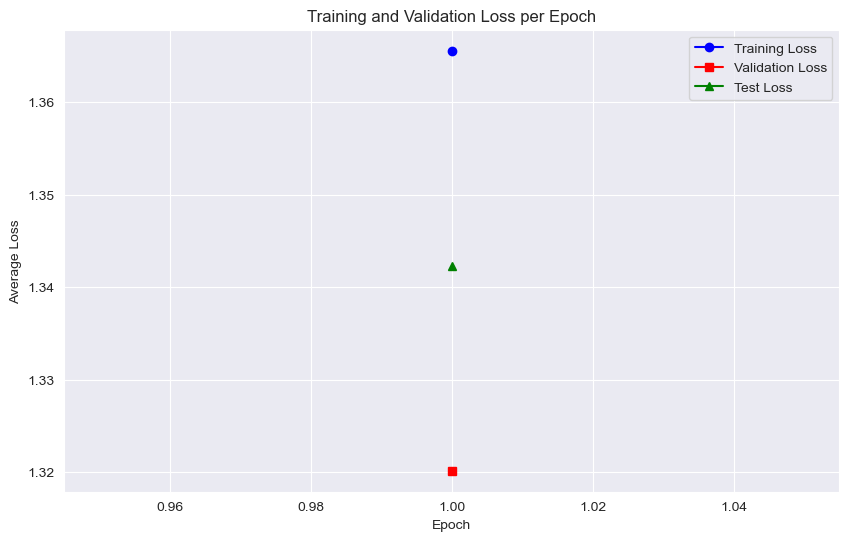

Epoch 2/100, Training Loss: 1.2884 Validation Loss: 1.2380 Test Loss: 1.2650
Epoch Time: 230.45s, Estimated time remaining: 22584.44s



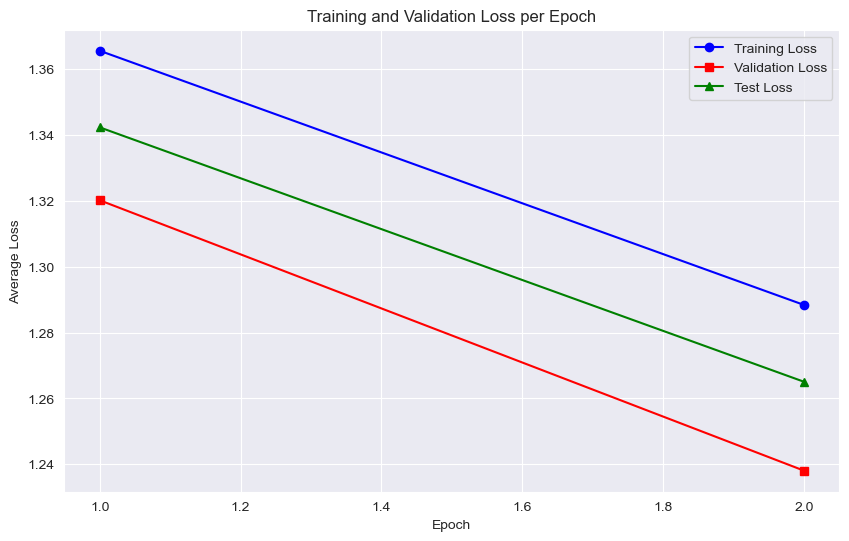

Epoch 3/100, Training Loss: 1.2293 Validation Loss: 1.1836 Test Loss: 1.2322
Epoch Time: 243.80s, Estimated time remaining: 23648.43s



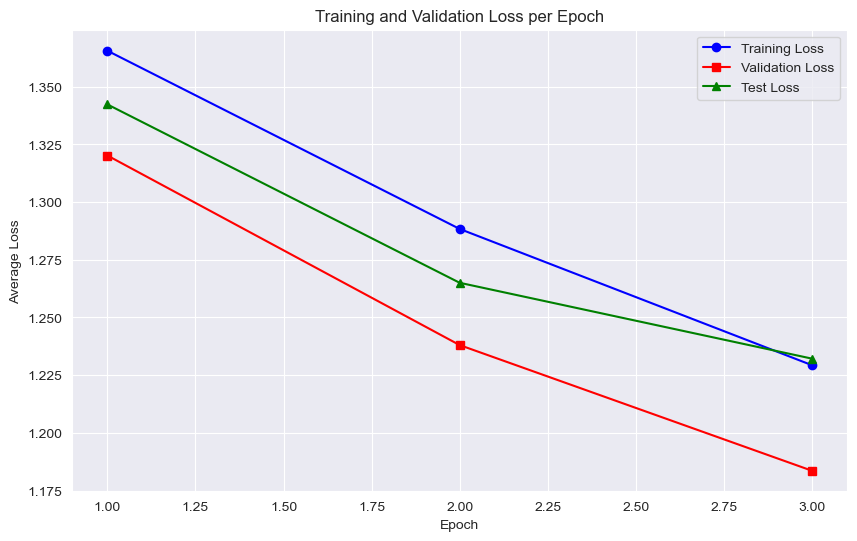

Epoch 4/100, Training Loss: 1.1879 Validation Loss: 1.1270 Test Loss: 1.1682
Epoch Time: 241.08s, Estimated time remaining: 23143.61s



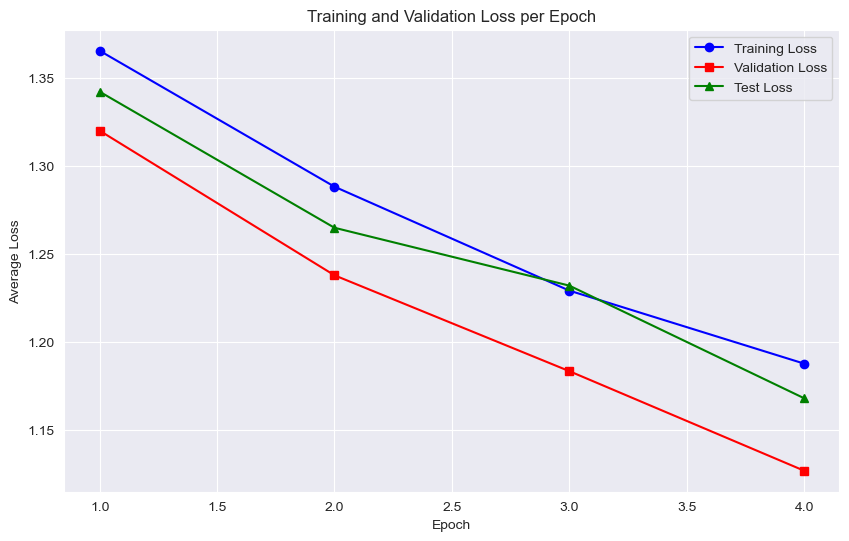

Epoch 5/100, Training Loss: 1.1582 Validation Loss: 1.1052 Test Loss: 1.1752
Epoch Time: 235.59s, Estimated time remaining: 22380.78s



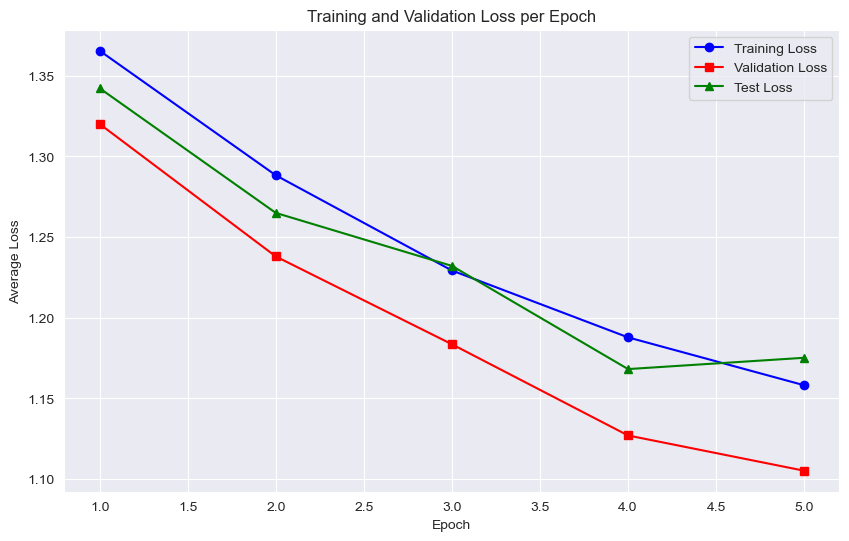

Epoch 6/100, Training Loss: 1.1260 Validation Loss: 1.1113 Test Loss: 1.1994
No improvement for 1 epoch(s).
Epoch Time: 237.80s, Estimated time remaining: 22353.15s



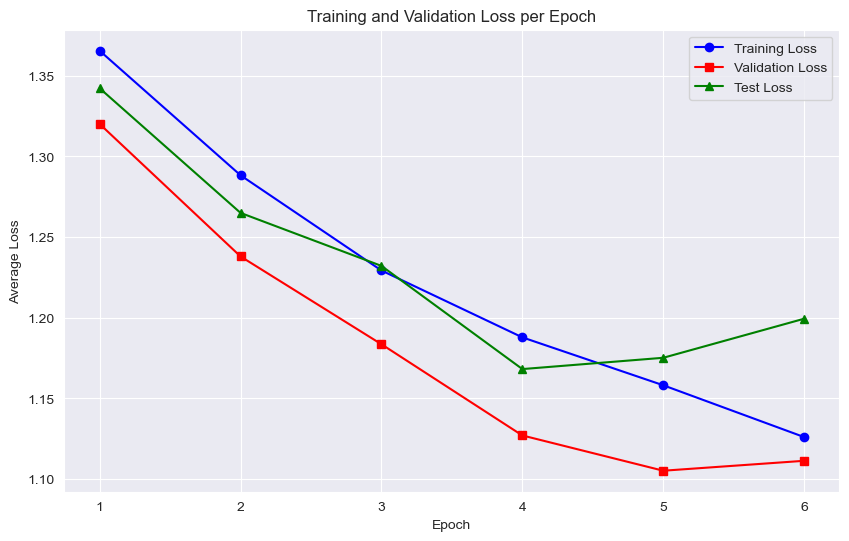

Epoch 7/100, Training Loss: 1.1189 Validation Loss: 1.0751 Test Loss: 1.1737
Epoch Time: 230.00s, Estimated time remaining: 21389.71s



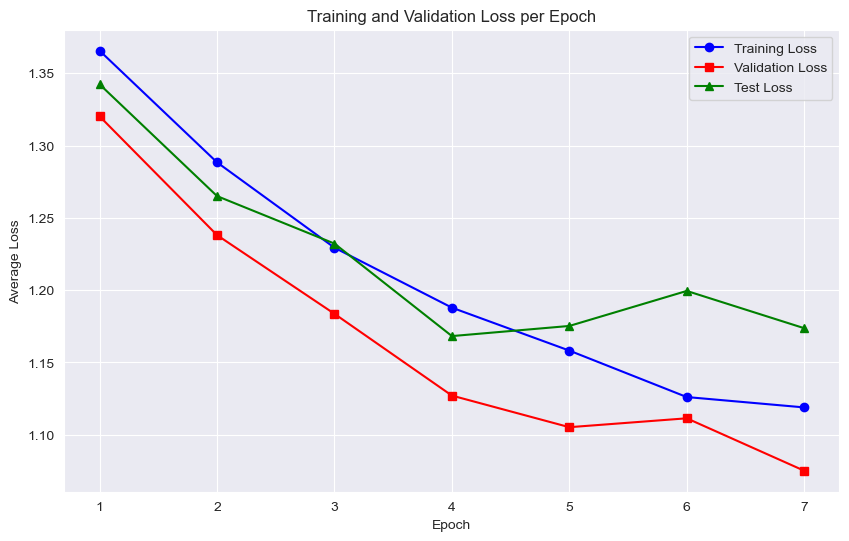

Epoch 8/100, Training Loss: 1.1031 Validation Loss: 1.0034 Test Loss: 1.0737
Epoch Time: 227.25s, Estimated time remaining: 20906.94s



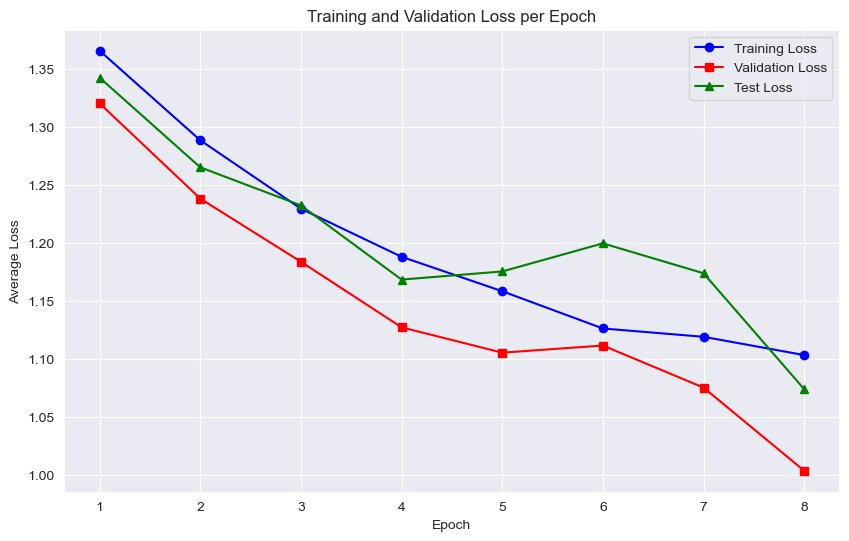

Epoch 9/100, Training Loss: 1.0819 Validation Loss: 1.1280 Test Loss: 1.1698
No improvement for 1 epoch(s).
Epoch Time: 238.41s, Estimated time remaining: 21695.63s



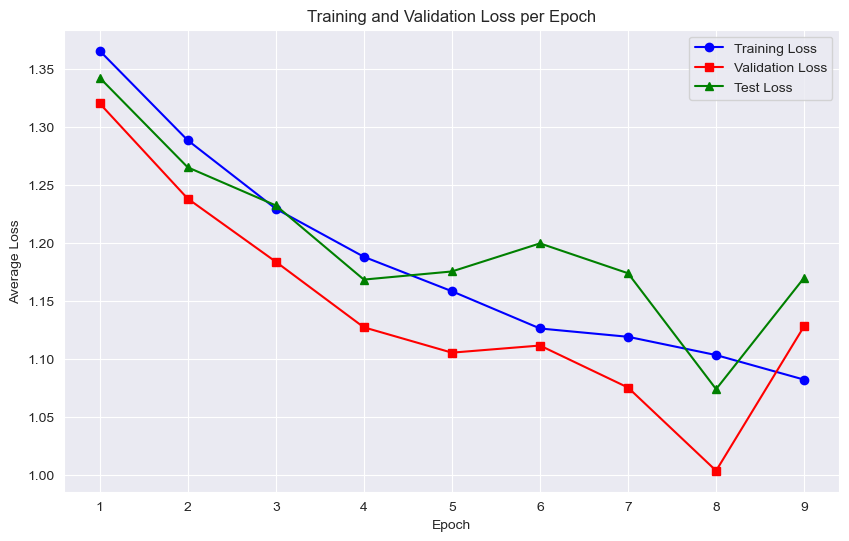

Epoch 10/100, Training Loss: 1.0648 Validation Loss: 1.0480 Test Loss: 1.1163
No improvement for 2 epoch(s).
Epoch Time: 240.71s, Estimated time remaining: 21663.61s



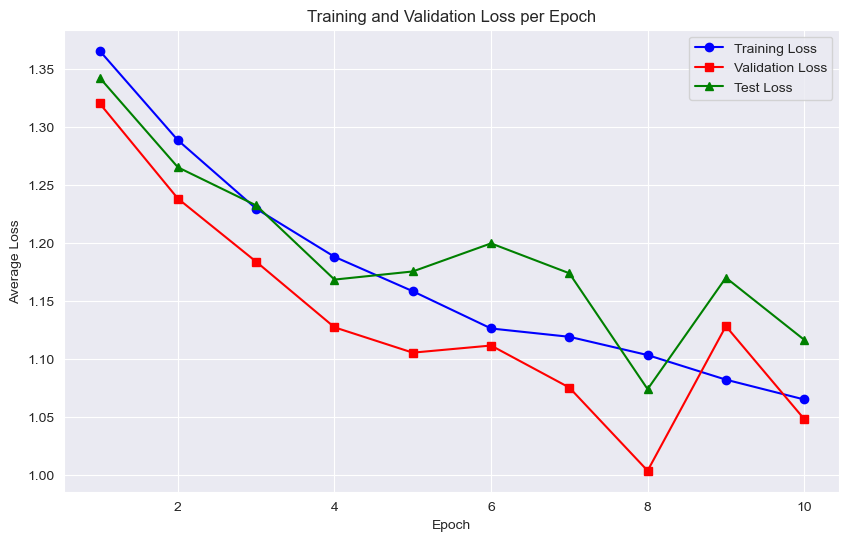

Epoch 11/100, Training Loss: 1.0531 Validation Loss: 1.0452 Test Loss: 1.1078
No improvement for 3 epoch(s).
Epoch Time: 246.78s, Estimated time remaining: 21963.20s



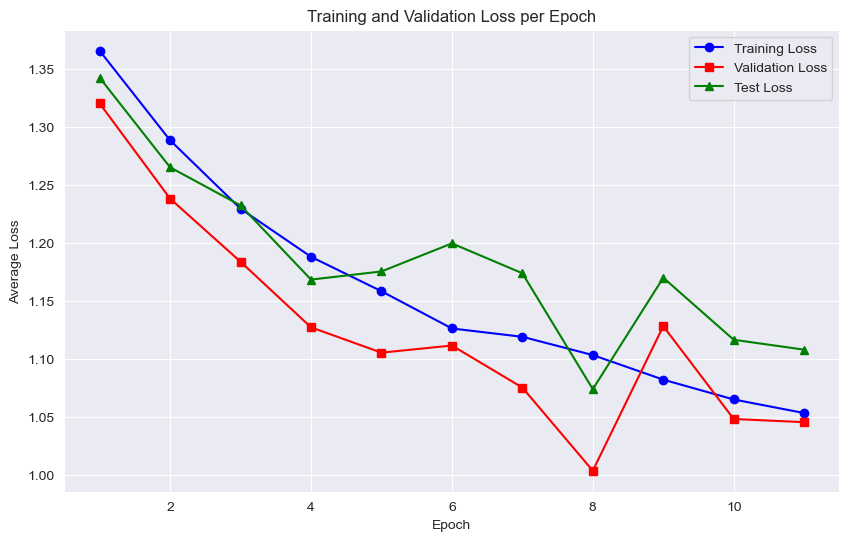

Epoch 12/100, Training Loss: 1.0499 Validation Loss: 1.0465 Test Loss: 1.1262
No improvement for 4 epoch(s).
Epoch Time: 233.28s, Estimated time remaining: 20528.35s



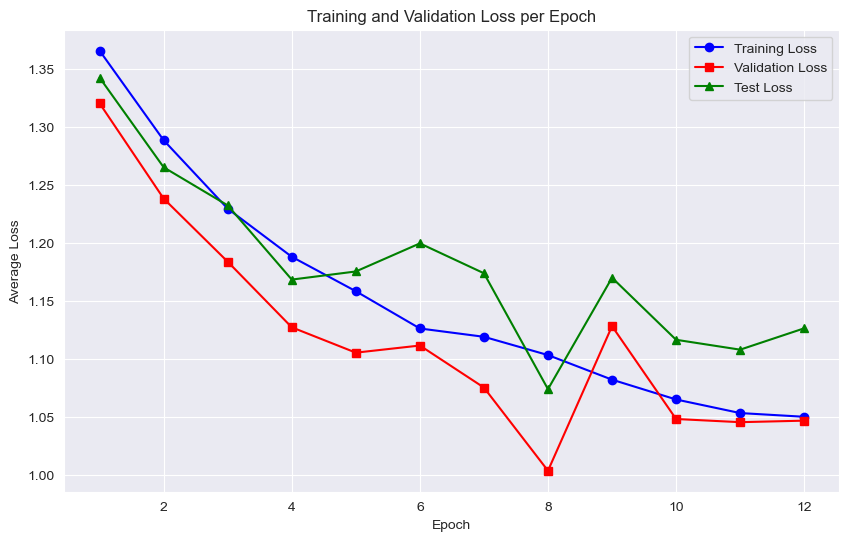

Epoch 13/100, Training Loss: 1.0461 Validation Loss: 1.0144 Test Loss: 1.0775
No improvement for 5 epoch(s).
Validation loss has not improved after many consecutive epochs. Early stopping triggered.
Training complete.
Best model loaded based on validation loss.


In [31]:
# CNN for size 322 by 322 ie. the max shape of the images
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1: Input 3 x 322 x 322 -> Conv -> 16 x 322 x 322, then maxpool to 16 x 161 x 161
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 2: 16 x 161 x 161 -> Conv -> 32 x 161 x 161, then maxpool to 32 x 80 x 80
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 3: 32 x 80 x 80 -> Conv -> 64 x 80 x 80, then maxpool to 64 x 40 x 40
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Extra pooling to reduce feature map size from 40 x 40 to 20 x 20
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 20 * 20, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for the classifier
        x = self.classifier(x)
        return x


class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: Input 3 x 322 x 322 -> Two conv layers -> MaxPool to 32 x 161 x 161
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2: 32 x 161 x 161 -> Two conv layers -> MaxPool to 64 x 80 x 80
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3: 64 x 80 x 80 -> Two conv layers -> MaxPool to 128 x 40 x 40
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 4: 128 x 40 x 40 -> Two conv layers -> MaxPool to 256 x 20 x 20
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Global average pooling to reduce the feature map to 1x1 per channel.
        # This helps cut down the number of parameters in the classifier.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)  # Now x has shape (batch_size, 256, 1, 1)
        x = x.view(x.size(0), -1)      # Flatten to (batch_size, 256)
        x = self.classifier(x)
        return x


class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(ResNetTransferLearning, self).__init__()

        # Load a pre-trained ResNet model (e.g., ResNet50)
        self.resnet = models.resnet50(pretrained=True)

        # Freeze the layers of ResNet (except for the classifier)
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Modify the final layer to match the number of classes in your dataset
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

class EfficientNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetTransferLearning, self).__init__()

        # Load pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)  # You can use different variants like b0, b1, etc.

        # Freeze all layers in EfficientNet except the classifier
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Modify the final fully connected layer (classifier)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

class DenseNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetTransferLearning, self).__init__()

        # Load pre-trained DenseNet model
        self.densenet = models.densenet121(pretrained=True)  # You can use densenet121, densenet169, etc.

        # Freeze all layers in DenseNet except the classifier
        for param in self.densenet.parameters():
            param.requires_grad = False

        # Modify the final fully connected layer (classifier)
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Assume the number of classes is determined by your label mapping:
num_classes = len(label_to_index)
model = ResNetTransferLearning(num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 1
best_model_state = None  # Will hold the best model weights

# Training and Evaluation Loop
num_epochs = 100
training_losses = []
validation_losses = []
test_losses = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    epoch_start = time.time()  # Start time for the epoch
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           # Zero the gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    training_losses.append(epoch_loss)

    # TEST EVALUATION
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # VALIDATION EVALUATION
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    validation_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f} Validation Loss: {epoch_val_loss:.4f} Test Loss: {epoch_test_loss:.4f}")
    
    # --- Early Stopping Check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= patience:
            print("Validation loss has not improved after many consecutive epochs. Early stopping triggered.")
            break
    
    # UNCOMMENT IF YOU WANT TO EVALUATE THE TEST ACCURACY EVERY EPOCH
    # --- Evaluation ---
    # model.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, preds = torch.max(outputs, 1)
    #         correct += (preds == labels).sum().item()
    #         total += labels.size(0)
    # accuracy = correct / total
    # print(f"Test Accuracy: {accuracy:.4f}")

    epoch_end = time.time()  # End time for the epoch
    epoch_duration = epoch_end - epoch_start
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_time_remaining = epoch_duration * remaining_epochs
    print(f"Epoch Time: {epoch_duration:.2f}s, Estimated time remaining: {estimated_time_remaining:.2f}s\n")

    epochs = range(1, len(training_losses) + 1)  # Create epoch numbers starting at 1

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, validation_losses, marker='s', linestyle='-', color='r', label='Validation Loss')
    plt.plot(epochs, test_losses, marker='^', linestyle='-', color='g', label='Test Loss')
    plt.title("Training and Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

print("Training complete.")

# Load the best model weights (if they were saved) so that further evaluations use the best model.
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model loaded based on validation loss.")
else:
    print("No best model was saved during training.")


Plot training losses

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland     0.3364    0.4805    0.3957        77
                  Other     0.4839    0.5660    0.5217       106
             Plantation     0.7054    0.6766    0.6907       269
Smallholder agriculture     0.5625    0.4583    0.5051       216

               accuracy                         0.5659       668
              macro avg     0.5220    0.5454    0.5283       668
           weighted avg     0.5815    0.5659    0.5699       668



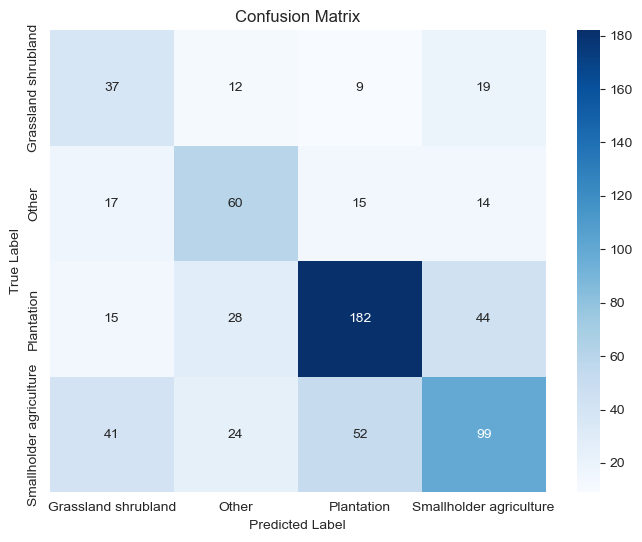

In [32]:
# Create a mapping to convert indices back to labels (for display purposes)
index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in range(num_classes)]

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report (includes precision, recall, and F1 score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap to display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()